# MNIST Binary CNN

In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import shutil
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils import plot_model

In [37]:
# Consts
image_height = 28
image_width = 28

In [38]:
# Paths
root_path = os.path.join(os.getcwd())
image_path = os.path.join(root_path, 'data', 'mnist_binary')
train_path = os.path.join(image_path, 'train')
test_path = os.path.join(image_path, 'test')
binary = os.path.join(root_path, 'model_output', 'binary')
h5_model = os.path.join(binary, 'mnist_binary.h5')
json_model = os.path.join(binary, 'mnist_binary.json')
model_plot = os.path.join(binary, 'model_plot_binary.png')
model_tflite = os.path.join(binary, 'model_binary.tflite')

In [39]:
# Remove old entries
if os.path.exists(binary):
    shutil.rmtree(binary)
os.makedirs(binary)    

In [49]:

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (image_width, image_height, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(0.5))

# output layer
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 5, 5, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 3, 3, 64)          18496     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 1, 1, 64)         

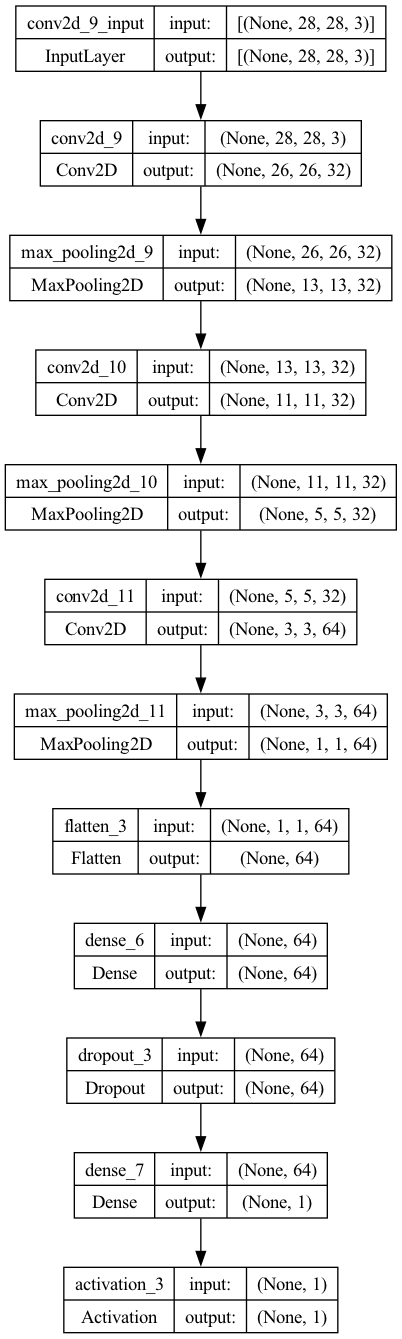

In [41]:
plot_model(model, to_file=model_plot, show_shapes=True, show_layer_names=True)

In [42]:
# Model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# DataGen
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

# Tain and Test
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (image_height, image_width),
                                                 batch_size = 32,
                                                 class_mode = "binary")

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (image_height, image_width),
                                            batch_size = 32,
                                            class_mode = "binary")

# Get the prediction order
class_indices = training_set.class_indices
print(class_indices)


Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
{'five': 0, 'not_five': 1}


In [43]:
# FIT!
history = model.fit(training_set,
                     batch_size=32,
                     epochs=4,
                     validation_data=test_set)

Epoch 1/4
10/10 [==============================] - 0s 26ms/step - loss: 0.6346 - accuracy: 0.7250 - val_loss: 0.4884 - val_accuracy: 0.9250
Epoch 2/4
10/10 [==============================] - 0s 17ms/step - loss: 0.3568 - accuracy: 0.9469 - val_loss: 0.1726 - val_accuracy: 0.9375
Epoch 3/4
10/10 [==============================] - 0s 18ms/step - loss: 0.1327 - accuracy: 0.9719 - val_loss: 0.1107 - val_accuracy: 0.9375
Epoch 4/4
10/10 [==============================] - 0s 18ms/step - loss: 0.0687 - accuracy: 0.9750 - val_loss: 0.0298 - val_accuracy: 0.9875


In [44]:
# Save Model
model.save(h5_model)

/Users/sam.treweek/BJSS/Node/playwright-classification/cnn/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


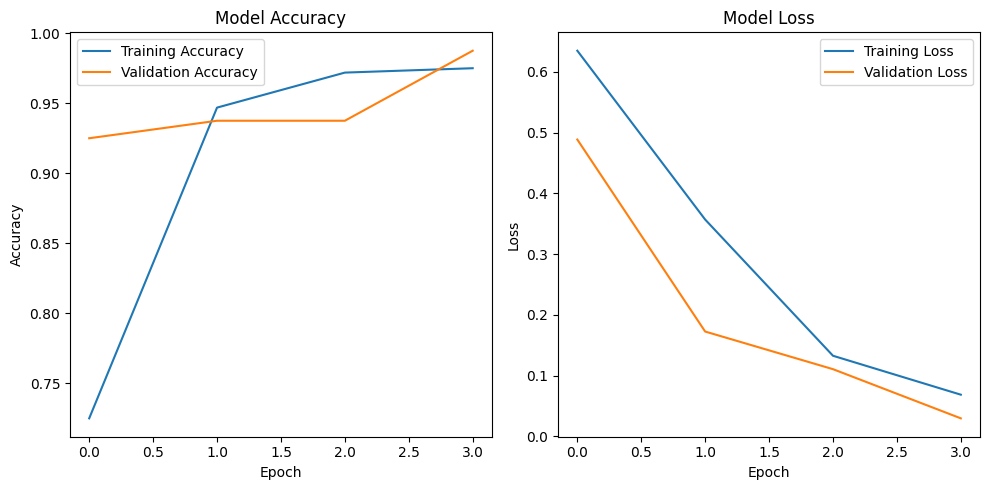

In [45]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [47]:
# Convert to lite
keras_model = keras.models.load_model(h5_model)

converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()

with open(model_tflite, 'wb') as f:
    f.write(tflite_model) 

INFO:tensorflow:Assets written to: /var/folders/sm/5vqnl48x7lx67_t13wmr4vlr0000gq/T/tmpdi_ih2sj/assets


INFO:tensorflow:Assets written to: /var/folders/sm/5vqnl48x7lx67_t13wmr4vlr0000gq/T/tmpdi_ih2sj/assets
2023-10-18 11:44:27.337855: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-18 11:44:27.337867: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.


In [48]:
!tensorflowjs_converter --input_format=keras {h5_model} {binary} --output_format=tfjs_layers_model